# Residuals

In order to evaluate our approach so far, let us examine the difference in residuals when sampling our doing predictions straight away.

Ultimately, this is what we want to use it for. Getting nice and realistic distributions from a tree that was never intended to model this distribution well (rmse tends to go for the middle in a bimodal distribution, for instance) is probably a pipe dream anyway, and perhaps not even what we need.

## Prelims

### Imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from sklearn.datasets import (make_friedman1,
                              make_friedman2,
                              make_friedman3)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

note_dir = os.getcwd()
root_dir = os.path.dirname(note_dir)
sys.path.append(root_dir)

import bonsai
from bonsai.base import *

### Functions

In [2]:
def plot_corr(corr):
    """
    Plot nicely formatted correlation matrix.
    """
    fig = plt.figure(figsize=((10,10))) # slightly larger
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='seismic')
    fig.colorbar(cax)
    
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', color='w')
    return 

In [3]:
def summarize_dataset(df, samples=1000, random_state=997, replace=False):
    """
    This function plots a grid of plots that give some insights into pairwise relationships between
    the attributes in the dataset.
    
    Explicit correlations or special distributions should be very visible here.
    """
    
    df_subsample = df.sample(n=samples, replace=False, random_state=random_state)
    
    sns.set(style="ticks", color_codes=True)
    g = sns.PairGrid(df_subsample) # slice every 10 otherwise a bit slow
    g = g.map_diag(plt.hist) # histograms on the diagonal
    g = g.map_lower(sns.kdeplot, cmap="Blues_d") # density plot on the lower plots
    g = g.map_upper(plt.scatter) # scatter plots on the upper plots
    return

## Dataset

In [4]:
# Synthetic DataSet using sklearn
X_1, y_1 = make_friedman1(n_samples=10**4, n_features=5, noise=1.0) 
X_2, y_2 = make_friedman1(n_samples=10**4, n_features=5, noise=1.0) 

X_2 += 0.25
y_2 += 30 # Bimodal Outcome


X = np.concatenate((X_1, X_2))
y = np.concatenate((y_1, y_2))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
df = pd.DataFrame(X_train)
df = df.assign(y=y_train)
df.head()

,0,1,2,3,4,y
0,0.530840,0.185909,0.051024,0.969564,0.679583,20.492817
1,0.120541,0.396199,0.889229,0.954331,0.315714,14.601627
2,0.344653,0.685712,0.472489,0.495432,0.676039,14.950796
3,0.257565,0.270073,0.286700,0.388068,0.840263,40.430447
4,0.289050,0.677675,0.556948,0.796110,0.367085,37.257028


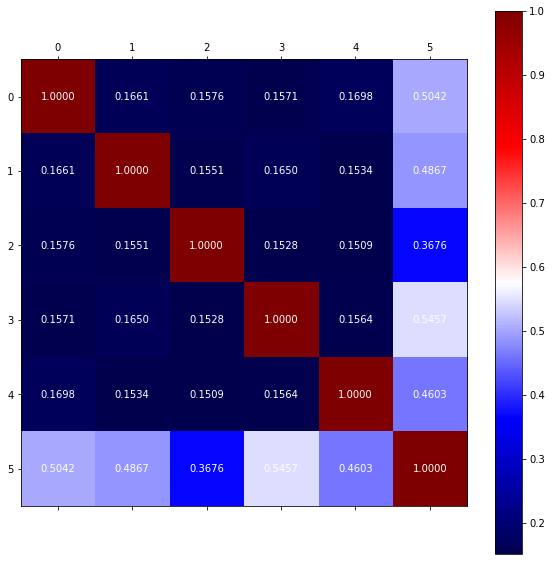

In [6]:
corr = df.corr().values
plot_corr(corr)

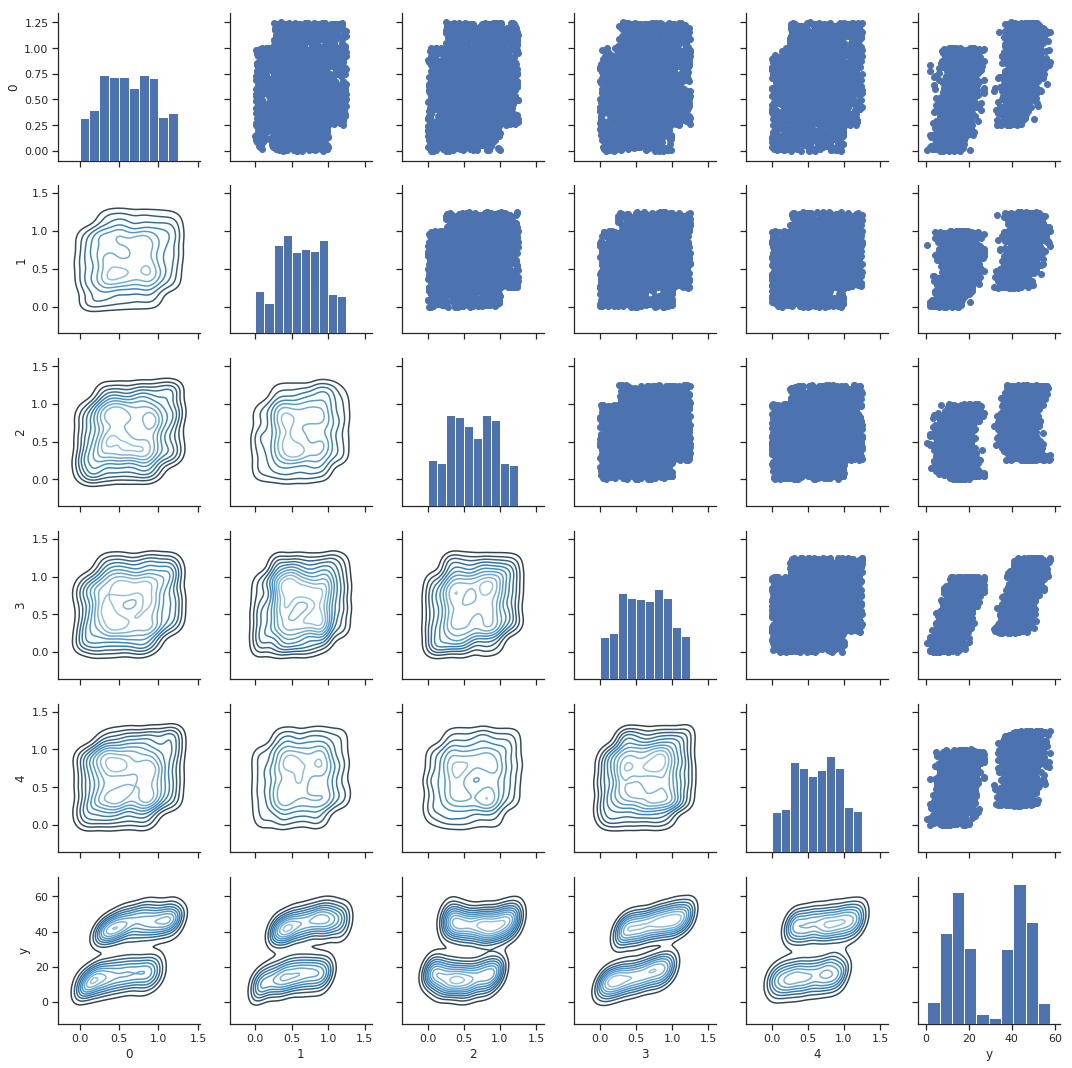

In [7]:
summarize_dataset(df, samples=2000)

## Trees

### Original Tree

In [8]:
# Initialize
max_depth = 10
regtree = RegTree(max_depth=max_depth )

# Fit
regtree.fit(X_train, y_train)

# Predict
reg_pred = regtree.predict(X_test)

rmse_original = np.sqrt(np.mean((y_test - reg_pred)**2))
rmse_original

8.905055167447092

The ideal outcome, bimodal so our tree does not learn this


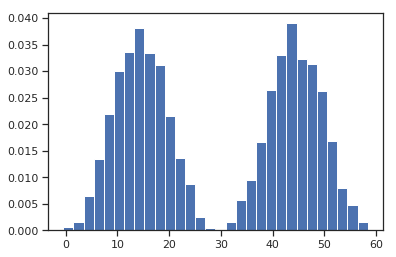

In [9]:
plt.hist(y_test, 30, density=True)
print("The ideal outcome, bimodal so our tree does not learn this")
plt.show()

RegTree minimizes RMSE and just aims right in the middle


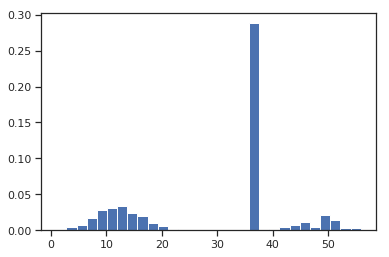

In [10]:
plt.hist(reg_pred, 30, density=True)
print("RegTree minimizes RMSE and just aims right in the middle")
plt.show()

In [26]:
# Initialize
c45tree = C45Tree(max_depth=max_depth )

# Fit
c45tree.fit(X_train, y_train)

# Predict
c45_pred = c45tree.predict(X_test)

rmse_original = np.sqrt(np.mean((y_test - c45_pred)**2))
rmse_original

10.027663665577117

In [ ]:
c45tree.pr

C45 shows a spectrum of outcomes that at least shows the bimodal outcome


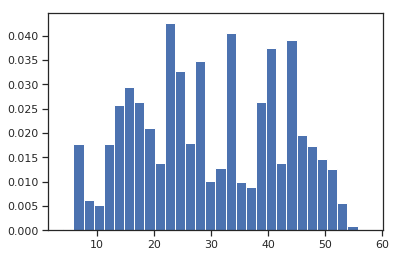

In [12]:
plt.hist(c45_pred, 30, density=True)
print("C45 shows a spectrum of outcomes that at least shows the bimodal outcome")
plt.show()

### Randomized Trees

In [13]:
def randomize(model, kind="swap", n=100):
    randomized_models = [model.randomize_tree(kind=kind) for _ in range(n)]
    return randomized_models 

In [14]:
reg_random_trees = randomize(regtree, kind="swap", n=100)

In [15]:
reg_random_pred = [m.predict(X_test) for m in reg_random_trees]

RegTree sampled outcomes


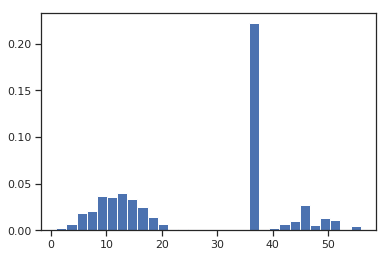

In [16]:
plt.hist(np.ravel(reg_random_pred), 30, density=True)
print("RegTree sampled outcomes")
plt.show()

In [17]:
c45_random_trees = randomize(c45tree, kind="swap", n=100)

In [18]:
c45_random_pred = [m.predict(X_test) for m in c45_random_trees]

C45 sampled outcomes


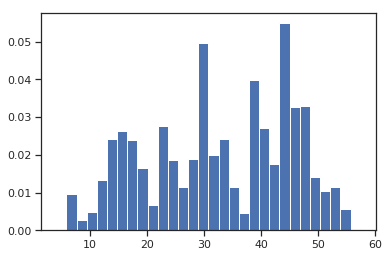

In [19]:
plt.hist(np.ravel(c45_random_pred), 30, density=True)
print("C45 sampled outcomes")
plt.show()

## Residuals

In [20]:
def residuals(y_test, y_pred, absolute=False):
    if isinstance(y_pred, np.ndarray):
        result = y_test-y_pred
        if absolute:
            result = np.abs(result)
    elif isinstance(y_pred, list):
        # Ravel to also get clean array
        result = np.ravel([residuals(y_test, pred, absolute=absolute) for pred in y_pred]) 
    return result

In [21]:
reg_residuals = residuals(y_test, reg_pred)

RegTree residuals


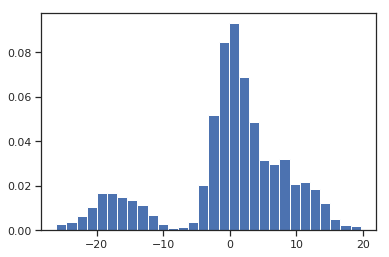

In [22]:
plt.hist(np.ravel(reg_residuals), 30, density=True)
print("RegTree residuals")
plt.show()

C45Tree residuals


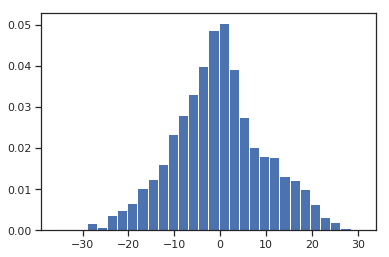

In [23]:
c45_residuals = residuals(y_test, c45_pred)
plt.hist(np.ravel(c45_residuals), 30, density=True)
print("C45Tree residuals")
plt.show()

### Randomized Residuals

Now, the point would be that it is clearly a different distribution.

RegTree Randomized Residuals


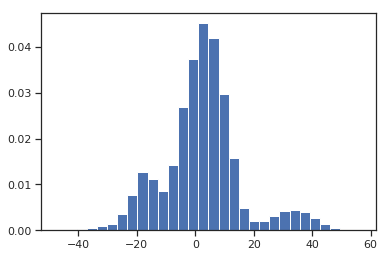

In [24]:
reg_random_residuals = residuals(y_test, reg_random_pred)
plt.hist(np.ravel(reg_random_residuals), 30, density=True)
print("RegTree Randomized Residuals")
plt.show()

C45 Tree Randomized Residuals


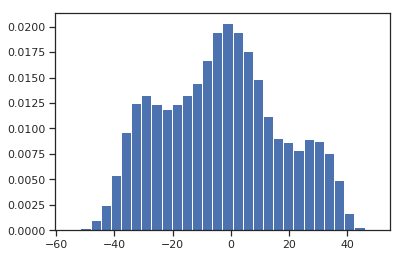

In [25]:
c45_random_residuals = residuals(y_test, c45_random_pred)
plt.hist(np.ravel(c45_random_residuals), 30, density=True)
print("C45 Tree Randomized Residuals")
plt.show()